In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import pylab
import os
from collections import Counter

import cv2
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

np.random.seed(2) # For reproducibility

# Constants and configuration settings can be imported
from src import config

# Auxiliary functions can be imported from src.dataset module
from src.dataset import get_image, get_mask, get_annotations, box_label, plot_boxes, plot_mask, overlay_mask

if "notebooks" in os.getcwd():
    print("Running in Jupyter Notebook")

# Colors for the masks
COLORS = config.COLORS

# The analysis will be performed on Train dataset (check src.config)

annFile='{}/annotations/instances_attributes_{}.json'.format(config.dataDir,config.dataType) # Annotations json
maskFolder='{}/annotations/{}/'.format(config.dataDir, config.dataType)                      # Mask images
imgFolder='{}/images/{}/'.format(config.dataDir,config.dataType)

# initialize COCO api for instance annotations
db=COCO(annFile)                                                                             # Process the annotations in COCO format
d_cats = {x['id']: x['name'] for x in db.dataset['categories']}                              # Get the categories to encode/decode

for k, v in list(d_cats.items())[:5]:
    print(k, ":", v)

loading annotations into memory...
Done (t=7.41s)
creating index...
index created!
loading annotations into memory...
Done (t=8.43s)
creating index...
index created!
0 : shirt, blouse
1 : top, t-shirt, sweatshirt
2 : sweater
3 : cardigan
4 : jacket


Image file: b030a75904244cb70840c003c019486d.jpg


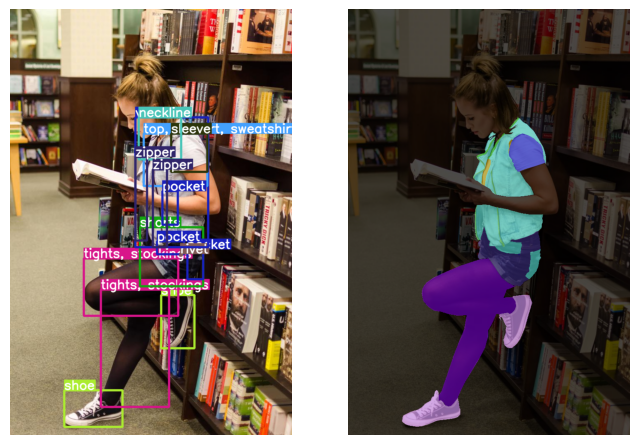

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ids = db.getImgIds()
rnd_id = np.random.choice(ids, 1)
plot_boxes(img_id=rnd_id, ax=ax[0])

image_file = db.loadImgs(rnd_id)[0]['file_name']
print("Image file:", image_file)
overlay_mask(image_file, ax=ax[1])

# VOC PASCAL

In [3]:
pascal_dir = 'datasets/VOCdevkit/VOC2012'

images_dir = os.path.join(pascal_dir, 'JPEGImages')
segmentation_dir = os.path.join(pascal_dir, 'SegmentationClass')

def get_random_image_pascal():
    # Get a random image from the dataset and return the image and the mask
    mask_files = os.listdir(segmentation_dir)
    rnd_file = np.random.choice(mask_files, 1)[0]
    mask_file = os.path.join(segmentation_dir, rnd_file)
    image_file = os.path.join(images_dir, rnd_file[:-4] + '.jpg')
    
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # print("Image file:", image_file)
    # print("Mask file:", mask_file)
    mask = cv2.imread(mask_file)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    mask = make_boolean_mask(mask)

    
    return image, mask

def make_boolean_mask(mask):
    avoid_colors = np.array([[0, 0, 0], [224, 224, 192]])
    
    # Get unique colors in the mask
    colors = np.unique(mask.reshape(-1, mask.shape[2]), axis=0)
    
    # Create a boolean mask to identify rows not in avoid_colors
    mask_colors = ~np.isin(colors, avoid_colors).all(axis=1)
    filtered_colors = colors[mask_colors]

    # Get one random colors from filtered colors
    if filtered_colors.shape[0] == 0:
        color = colors[np.random.choice(colors.shape[0], 1)[0]]
    else:
        color = filtered_colors[np.random.choice(filtered_colors.shape[0], 1)[0]]
    
    mask = np.all(mask == color, axis=2)    
    
    return mask  
    

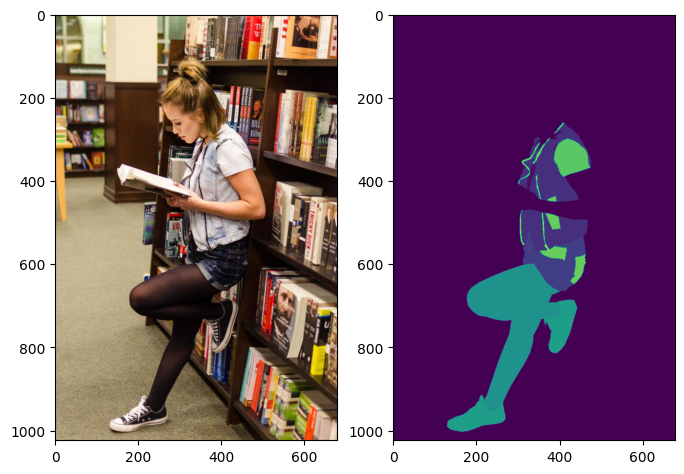

In [4]:
image = get_image(rnd_id)
mask = get_mask(rnd_id)

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(image)
ax[1].imshow(mask)



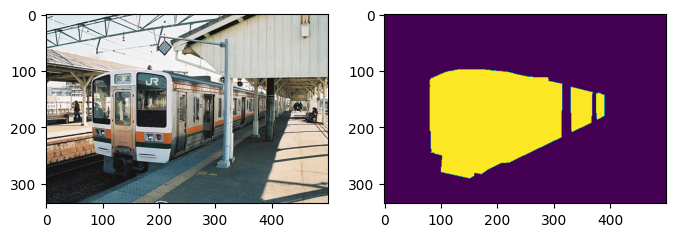

In [5]:
image_pascal, mask_pascal = get_random_image_pascal()

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(image_pascal)
ax[1].imshow(mask_pascal)

In [6]:

def rotate_image_without_cropping(img, angle):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    # Calculate the size of the new image
    abs_cos, abs_sin = abs(np.cos(np.radians(angle))), abs(np.sin(np.radians(angle)))
    bound_w = int(h * abs_sin + w * abs_cos)
    bound_h = int(h * abs_cos + w * abs_sin)
    # Adjust the rotation matrix to the center and apply the padding
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotation_matrix[0, 2] += bound_w / 2 - center[0]
    rotation_matrix[1, 2] += bound_h / 2 - center[1]
    rotated_img = cv2.warpAffine(img, rotation_matrix, (bound_w, bound_h))
    return rotated_img

In [7]:
def superpose_pascal_crop(image, mask, image_pascal, mask_pascal):
    
    width, height = image.shape[:2]
    width_pascal, height_pascal = image_pascal.shape[:2]
    
    
    cropped_image_pascal = image_pascal.copy()
    mask_pascal = mask_pascal.astype(bool)
    cropped_image_pascal[~mask_pascal] = 0
    
    # Crop the cropped image so that it has no black borders (rows and columns)
    min_x = np.min(np.where(mask_pascal)[1])
    max_x = np.max(np.where(mask_pascal)[1])
    min_y = np.min(np.where(mask_pascal)[0])
    max_y = np.max(np.where(mask_pascal)[0])
    cropped_image_pascal = cropped_image_pascal[min_y:max_y, min_x:max_x]
    mask_pascal = mask_pascal[min_y:max_y, min_x:max_x]
    width_pascal, height_pascal = cropped_image_pascal.shape[:2]
    
    
    
    
    ### ROTATION ###
    # Add some random rotation to the Pascal image
    angle = np.random.randint(-45, 45)
    cropped_image_pascal = rotate_image_without_cropping(cropped_image_pascal, angle)
    mask_pascal = rotate_image_without_cropping(mask_pascal.astype(np.uint8), angle)
    mask_pascal = mask_pascal.astype(bool)
    
    width_pascal, height_pascal = cropped_image_pascal.shape[:2]
    ##############################################

    
    ### RESIZE ###
    # Resize randomly the Pascal image
    min_scale = 0.8
    max_scale = min(width / width_pascal, height / height_pascal)
    
    scale = np.random.uniform(min_scale, max_scale)
    width_pascal = int(width_pascal * scale)
    height_pascal = int(height_pascal * scale)
    
    
    cropped_image_pascal = cv2.resize(cropped_image_pascal, (height_pascal, width_pascal))
    mask_pascal = cv2.resize(mask_pascal.astype(np.uint8), (height_pascal, width_pascal))
    mask_pascal = mask_pascal.astype(bool)
    width_pascal, height_pascal = cropped_image_pascal.shape[:2]
    
    
    # If the resulted image is larger than the original image, crop the extra pixels
    if width_pascal > width or height_pascal > height:
        x = (width_pascal - width) // 2
        y = (height_pascal - height) // 2
        cropped_image_pascal = cropped_image_pascal[x:x+width, y:y+height]
        mask_pascal = mask_pascal[x:x+width, y:y+height]
        width_pascal, height_pascal = cropped_image_pascal.shape[:2]
    
    ##############################################
    
    ### OFFSET ###
    # Calculate center position for superposition
    x = (width - width_pascal) // 2
    y = (height - height_pascal) // 2
    
    # Add some random offset to the center position
    offset_x = np.random.randint(-x//3, x//3) if x > 0 else 0
    offset_y = np.random.randint(-y//2, y//2) if y > 0 else 0
    
    x = max(0, x + offset_x)
    y = max(0, y + offset_y)
    
    ##############################################
    # assert x >= 0 and y >= 0, "Invalid position"
    # assert x + width_pascal <= width and y + height_pascal <= height, "Invalid position"
    print("Offset x:", offset_x, "Offset y:", offset_y, "Rotation angle:", angle, "Scale:", scale, "Center x:", x, "Center y:", y)
    
    # Superpose Pascal image on the original image at the calculated center position
    overlaid_image = image.copy()
    
     # Create a mask for the Pascal image where mask_pascal is True
    pascal_mask = np.zeros_like(mask, dtype=bool)
    pascal_mask[x:x+width_pascal, y:y+height_pascal] = mask_pascal
    
    # Overlay Pascal image on the original image at the calculated center position
    overlaid_image = image.copy()
    overlaid_image[pascal_mask] = cropped_image_pascal[mask_pascal]
    
    overlaid_mask = mask.copy() 
    overlaid_mask[pascal_mask] = 0
    
    
    
    return overlaid_image, overlaid_mask


Offset x: -24 Offset y: -37 Rotation angle: 27 Scale: 1.3897483602433442 Center x: 272 Center y: 50


(-0.5, 677.5, 1023.5, -0.5)

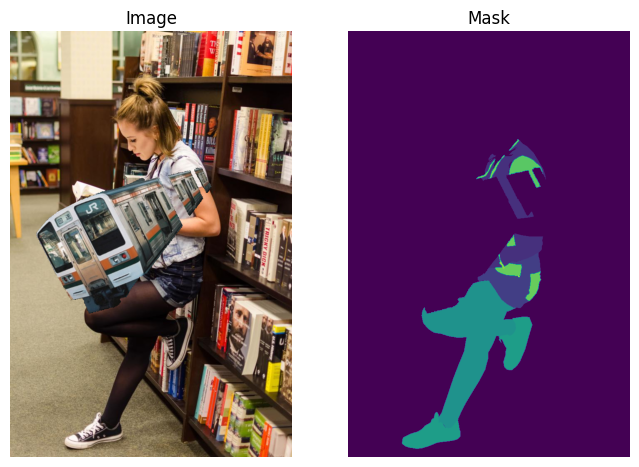

In [8]:
final_image, final_mask = superpose_pascal_crop(image, mask, image_pascal, mask_pascal)

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(final_image)
ax[1].imshow(final_mask)
ax[0].set_title("Image")
ax[1].set_title("Mask")
ax[0].axis('off')
ax[1].axis('off')


Fashion list: [28985, 26959, 31879, 12321, 1291, 27545, 12783, 38801, 46549, 48137]
Offset x: 21 Offset y: -60 Rotation angle: 35 Scale: 1.49777060946096 Center x: 186 Center y: 160
Offset x: -46 Offset y: -36 Rotation angle: -41 Scale: 0.8659827247846095 Center x: 239 Center y: 113
Offset x: 99 Offset y: -40 Rotation angle: 1 Scale: 1.033634428051372 Center x: 499 Center y: 56
Offset x: 9 Offset y: 25 Rotation angle: -28 Scale: 2.5886042851579614 Center x: 332 Center y: 121
Offset x: 89 Offset y: -9 Rotation angle: 12 Scale: 1.0070322144109638 Center x: 390 Center y: 175
Offset x: -44 Offset y: -1 Rotation angle: -2 Scale: 2.0234518166701494 Center x: 112 Center y: 1
Offset x: -46 Offset y: -36 Rotation angle: -35 Scale: 1.1071692671089142 Center x: 272 Center y: 54
Offset x: -13 Offset y: -28 Rotation angle: 25 Scale: 6.916457847954677 Center x: 81 Center y: 140
Offset x: 4 Offset y: -56 Rotation angle: 37 Scale: 1.526313631146997 Center x: 235 Center y: 177
Offset x: 104 Offset y: 4

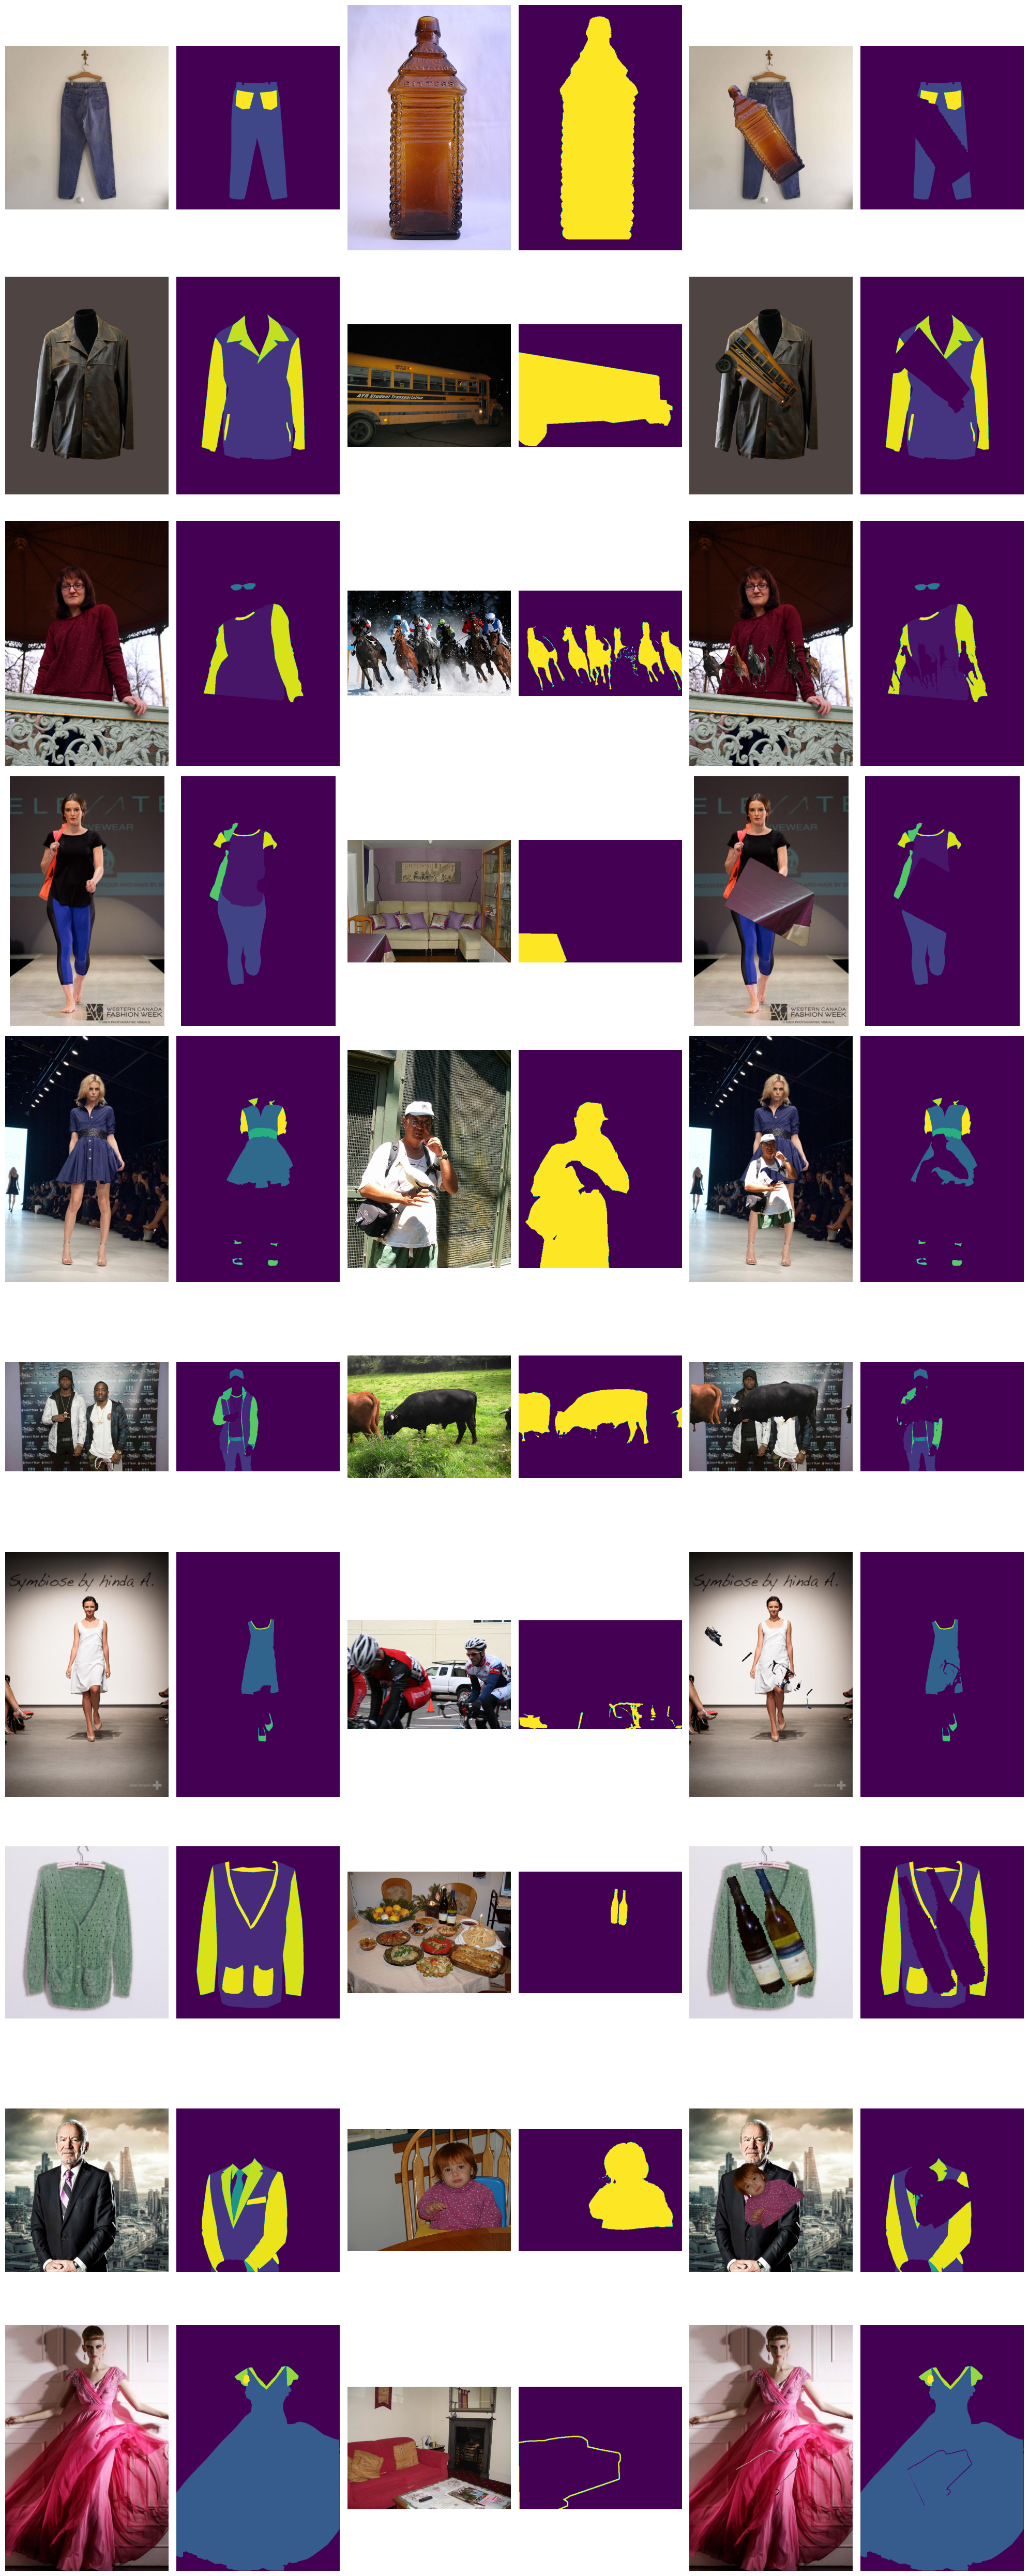

In [9]:
number_of_images = 10

fashion_list = list(np.random.choice(ids, number_of_images))
print("Fashion list:", fashion_list)
fashion_list = [(get_image(np.array([x])), get_mask(np.array([x]))) for x in fashion_list]

pascal_list = [get_random_image_pascal() for _ in range(number_of_images)]

# Plot the images
fig, ax = plt.subplots(number_of_images, 6, figsize=(20, 5 * number_of_images))
for i in range(number_of_images):
    ax[i, 0].imshow(fashion_list[i][0])
    ax[i, 1].imshow(fashion_list[i][1])
    
    ax[i, 2].imshow(pascal_list[i][0])
    ax[i, 3].imshow(pascal_list[i][1])
    
    final_image, final_mask = superpose_pascal_crop(fashion_list[i][0], fashion_list[i][1], pascal_list[i][0], pascal_list[i][1])
    ax[i, 4].imshow(final_image)
    ax[i, 5].imshow(final_mask)
    
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 3].axis('off')
    ax[i, 4].axis('off')
    ax[i, 5].axis('off')
    
plt.tight_layout()
    

The following code is to make sure that the pipeline in src.data_augmentation is working properly

Fashion list: [790, 19421, 16133, 22328, 11294, 36471, 23510, 39468, 7628, 855, 34136, 39867, 37888, 48650, 43687, 49412, 8862, 36836, 43379, 38913, 7474, 15780, 2144, 22589, 3507, 13815, 28852, 26607, 45062, 28995, 10520, 3889, 13762, 14497, 16573, 41632, 3713, 31341, 29979, 43084, 40475, 5736, 18167, 3859, 16008, 50286, 40870, 35251, 45381, 38006, 31911, 4454, 22623, 47627, 27, 49025, 30534, 17435, 19880, 5841, 45381, 4710, 12716, 45943, 41828, 12914, 6197, 3485, 37686, 8804, 3354, 40479, 11995, 19559, 44199, 10973, 32297, 35363, 24708, 40642, 26861, 5464, 37292, 11897, 11933, 21349, 22424, 12575, 11179, 6899, 5226, 42859, 7246, 48092, 39230, 47336, 13979, 3406, 48678, 12050, 28934, 38080, 23281, 11249, 19003, 42610, 10752, 35839, 22198, 48396, 50196, 26683, 1217, 47109, 25862, 49637, 28173, 28571, 4100, 24502, 25913, 27073, 48748, 29499, 43763, 36550, 5022, 10519, 15033, 11526, 40244, 24276, 13404, 47892, 33362, 17959, 45477, 18002, 10649, 2357, 42004, 27133, 38077, 7460, 17277, 238

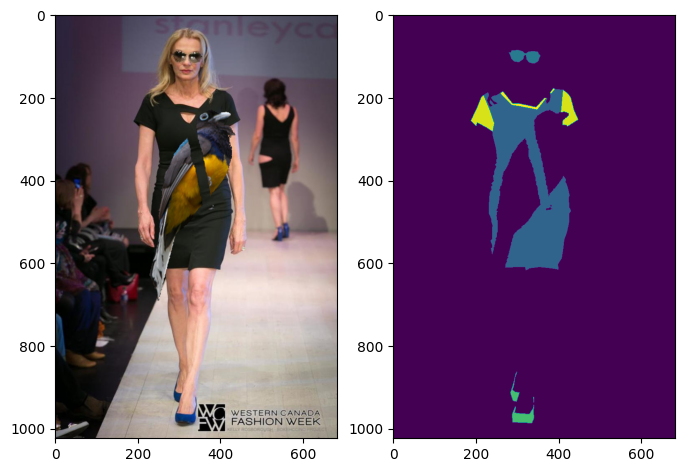

Image: 1
Offset x: 65 Offset y: -1 Rotation angle: 37 Scale: 1.4952445697987442 Center x: 265 Center y: 0
Overlaid image shape: (1024, 682, 3) Cropped image shape: (623, 680, 3) Mask Pascal shape: (623, 680) Pascal mask shape: (1024, 682)


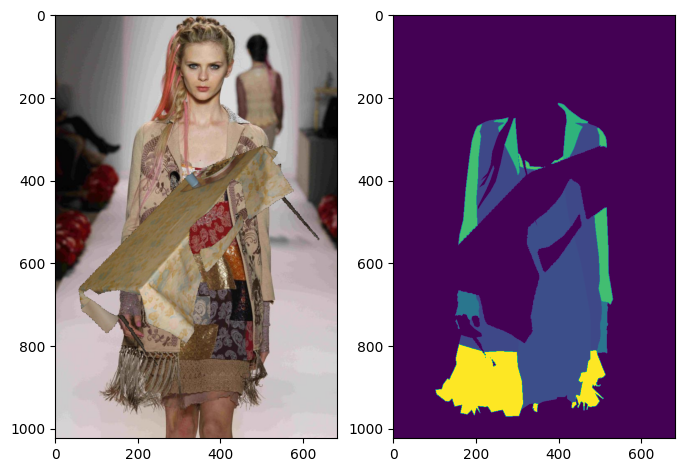

Image: 2
Offset x: 47 Offset y: -29 Rotation angle: 34 Scale: 0.871517488529619 Center x: 336 Center y: 94
Overlaid image shape: (1024, 739, 3) Cropped image shape: (445, 493, 3) Mask Pascal shape: (445, 493) Pascal mask shape: (1024, 739)


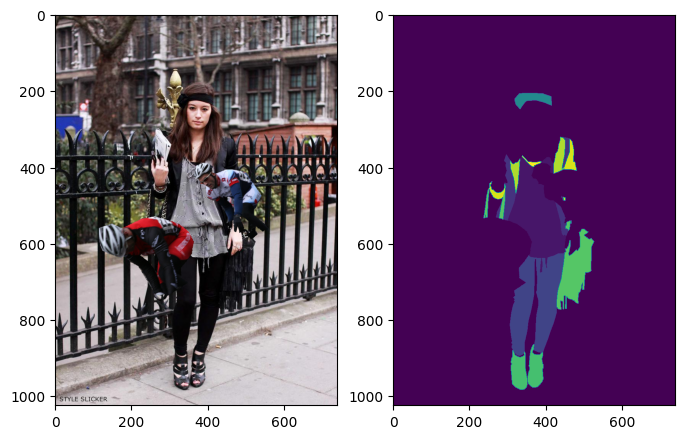

Image: 3
Offset x: -57 Offset y: -16 Rotation angle: 3 Scale: 2.17352186691888 Center x: 243 Center y: 52
Overlaid image shape: (1024, 682, 3) Cropped image shape: (423, 545, 3) Mask Pascal shape: (423, 545) Pascal mask shape: (1024, 682)


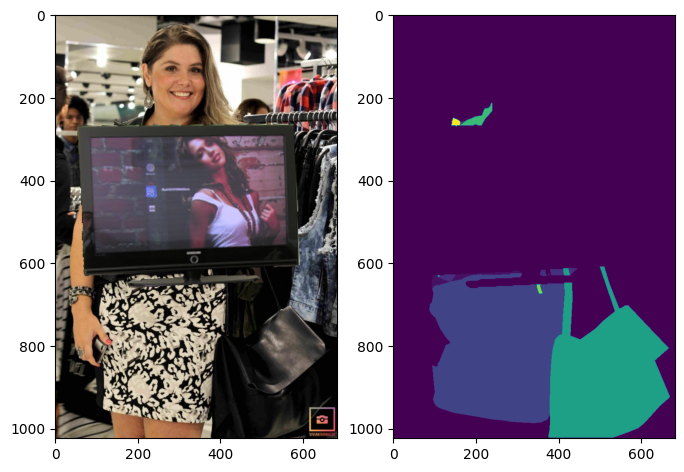

Image: 4
Offset x: -60 Offset y: 35 Rotation angle: -13 Scale: 1.0607777070856477 Center x: 289 Center y: 197
Overlaid image shape: (1024, 682, 3) Cropped image shape: (326, 358, 3) Mask Pascal shape: (326, 358) Pascal mask shape: (1024, 682)


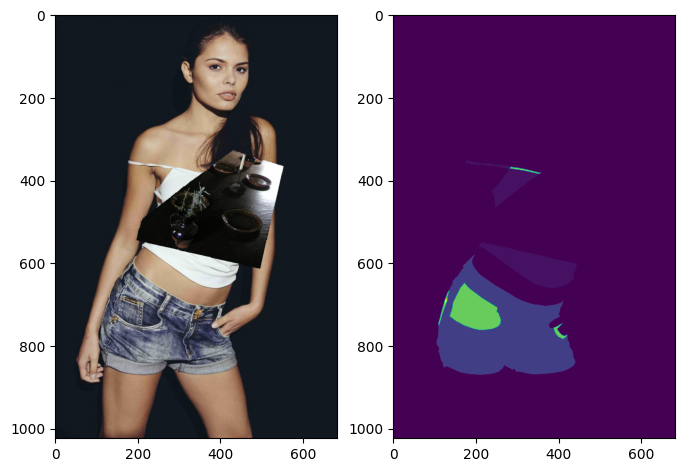

Image: 5
Offset x: 8 Offset y: 6 Rotation angle: -4 Scale: 1.8132510152711334 Center x: 346 Center y: 58
Overlaid image shape: (1024, 629, 3) Cropped image shape: (348, 525, 3) Mask Pascal shape: (348, 525) Pascal mask shape: (1024, 629)


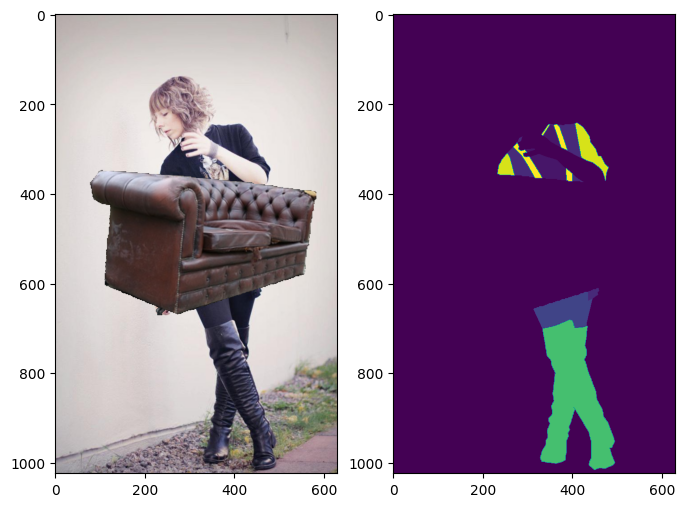

Image: 6
Offset x: -13 Offset y: 27 Rotation angle: -32 Scale: 2.2113900914691156 Center x: 37 Center y: 246
Overlaid image shape: (682, 1024, 3) Cropped image shape: (581, 586, 3) Mask Pascal shape: (581, 586) Pascal mask shape: (682, 1024)


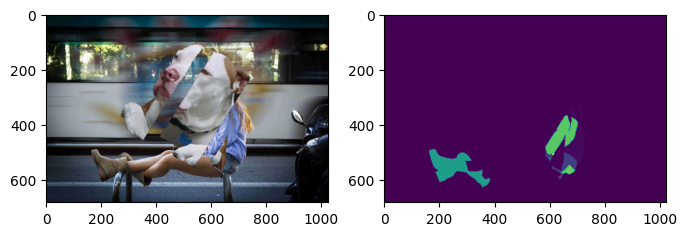

Image: 7
Offset x: -5 Offset y: -10 Rotation angle: -17 Scale: 2.2423885990166825 Center x: 30 Center y: 28
Overlaid image shape: (1024, 684, 3) Cropped image shape: (953, 607, 3) Mask Pascal shape: (953, 607) Pascal mask shape: (1024, 684)


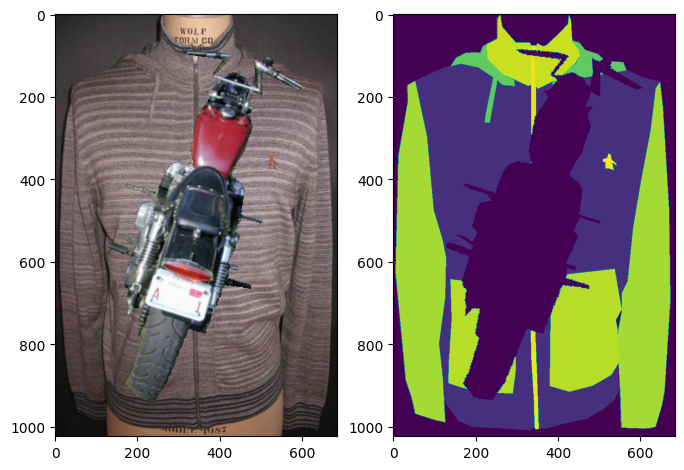

Image: 8
Offset x: 34 Offset y: -69 Rotation angle: -19 Scale: 0.8180653885357149 Center x: 264 Center y: 327
Overlaid image shape: (680, 1024, 3) Cropped image shape: (220, 231, 3) Mask Pascal shape: (220, 231) Pascal mask shape: (680, 1024)


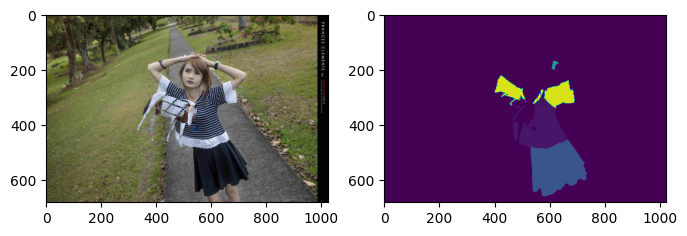

Image: 9
Offset x: 65 Offset y: 9 Rotation angle: -14 Scale: 0.9442346584283507 Center x: 374 Center y: 89
Overlaid image shape: (1024, 682, 3) Cropped image shape: (405, 522, 3) Mask Pascal shape: (405, 522) Pascal mask shape: (1024, 682)


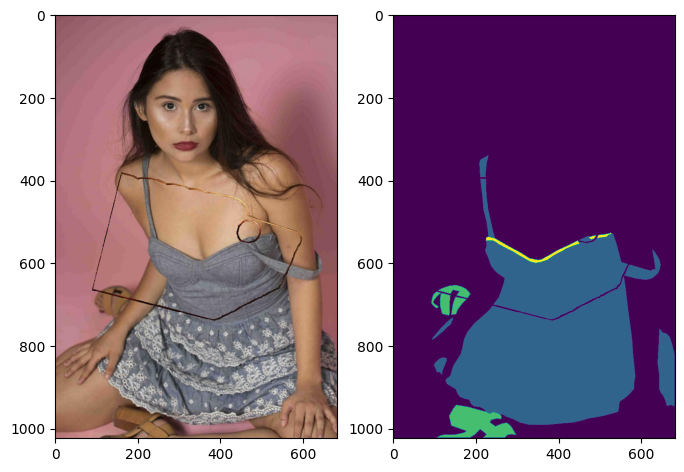

Image: 10
Offset x: 72 Offset y: 11 Rotation angle: -16 Scale: 1.8948219310477266 Center x: 303 Center y: 44
Overlaid image shape: (1024, 741, 3) Cropped image shape: (562, 674, 3) Mask Pascal shape: (562, 674) Pascal mask shape: (1024, 741)
Image: 11
Offset x: -78 Offset y: 22 Rotation angle: -39 Scale: 1.5362829012168389 Center x: 256 Center y: 193
Overlaid image shape: (1024, 681, 3) Cropped image shape: (356, 339, 3) Mask Pascal shape: (356, 339) Pascal mask shape: (1024, 681)
Image: 12
Offset x: 48 Offset y: 25 Rotation angle: -42 Scale: 1.0103977607899801 Center x: 394 Center y: 189
Overlaid image shape: (1024, 683, 3) Cropped image shape: (332, 355, 3) Mask Pascal shape: (332, 355) Pascal mask shape: (1024, 683)
Image: 13
Offset x: -20 Offset y: 3 Rotation angle: -14 Scale: 2.04429090562896 Center x: 138 Center y: 39
Overlaid image shape: (1024, 681, 3) Cropped image shape: (707, 609, 3) Mask Pascal shape: (707, 609) Pascal mask shape: (1024, 681)
Image: 14
Offset x: -4 Offset y

In [10]:
from src.data_augmentation import AddPascalCrop


number_of_images = 1000
fashion_list = list(np.random.choice(ids, number_of_images))
print("Fashion list:", fashion_list)
fashion_list = [(get_image(np.array([x])), get_mask(np.array([x]))) for x in fashion_list]

add_pascal_crop = AddPascalCrop(pascal_dataset_path=pascal_dir, prob=1.0)

for i in range(number_of_images):
    print("Image:", i)
    input_dict = dict(img=fashion_list[i][0], mask=fashion_list[i][1])
    
    result_dict = add_pascal_crop.transform(input_dict)
    final_image = result_dict['img']
    final_mask = result_dict['mask']
    
    if i < 10:
        fig, ax = plt.subplots(1, 2, figsize=(8, 8))
        ax[0].imshow(final_image)
        ax[1].imshow(final_mask)
        plt.show()
    